In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Loading and Preprocessing the Data

In [3]:
df = pd.read_csv(r"C:\Users\JIMMY ULAHANNAN\Downloads\Time Series Code Data\Alcohol_Sales.csv",index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [10]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq='MS')

In [6]:
df.columns = ['Sales']

### Visualizing the Data

<AxesSubplot:xlabel='DATE'>

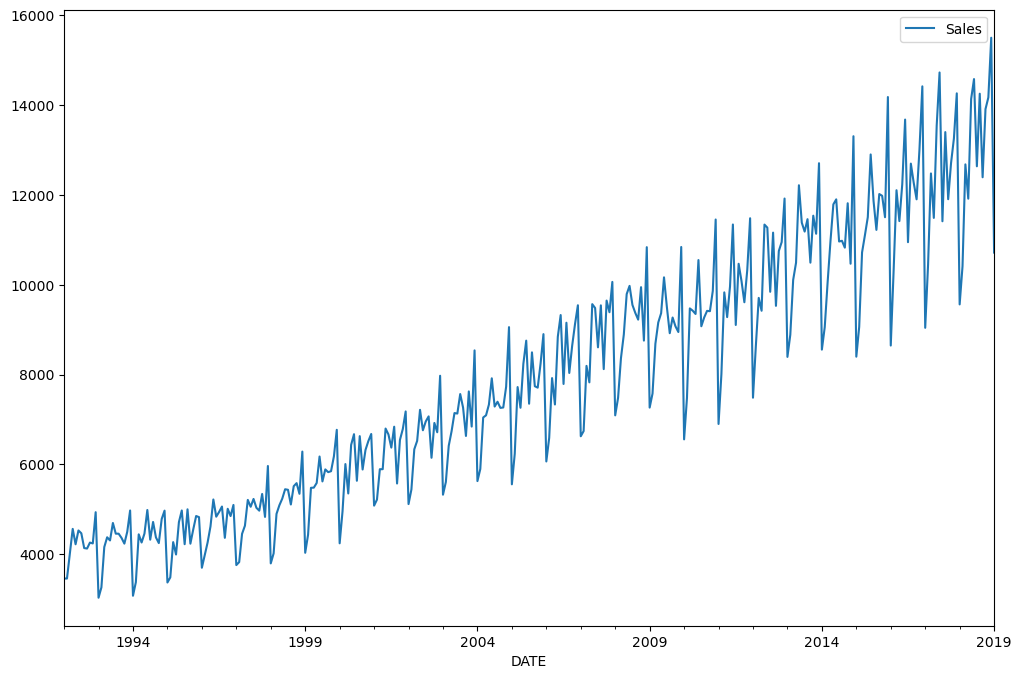

In [9]:
df.plot(figsize=(12,8))

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
results = seasonal_decompose(df['Sales'])

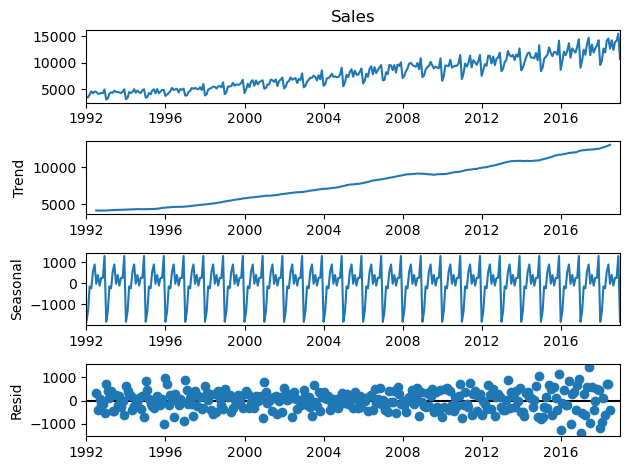

In [16]:
results.plot();

### Creating Training and Testing Sets

In [17]:
train = df.iloc[:313]
test = df.iloc[313:]

In [18]:
ser = np.array([23,56,2,13,14])

In [19]:
ser.max()

56

In [21]:
ser / ser.max()

array([0.41071429, 1.        , 0.03571429, 0.23214286, 0.25      ])

### Scaling the Data

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()

In [25]:
scaler.fit(train) # finds the max value in train data

MinMaxScaler()

In [26]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [27]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [33]:
n_input = 3
n_features = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [34]:
x,y=generator[0]

In [35]:
x

array([[[0.03658432],
        [0.03649885],
        [0.08299855]]])

In [36]:
y

array([[0.13103684]])

### Building the RNN Model

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [38]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [40]:
model = Sequential()
model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150)               91200     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [43]:
model.fit_generator(train_generator,epochs=25)

C:\Users\JIMMY ULAHANNAN\AppData\Local\Temp\ipykernel_12552\1408669387.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,epochs=25)


Epoch 1/25
301/301 [==============================] - 4s 8ms/step - loss: 0.0185
Epoch 2/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0093
Epoch 3/25
301/301 [==============================] - 2s 6ms/step - loss: 0.0083
Epoch 4/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0068
Epoch 5/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0056
Epoch 6/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0047
Epoch 7/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0033
Epoch 8/25
301/301 [==============================] - 2s 7ms/step - loss: 0.0031
Epoch 9/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0027
Epoch 10/25
301/301 [==============================] - 1s 5ms/step - loss: 0.0021
Epoch 11/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 12/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0020
Epoch 13/25
301/301 [====

In [44]:
model.history.history.keys()

dict_keys(['loss'])

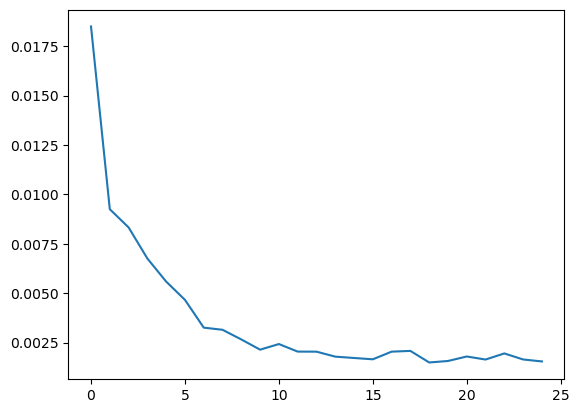

In [46]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss'])

### Evaluating and Making Predictions

In [47]:
# 12 history steps --> step 13
# last 12 points train --> pt 1 of test data

In [48]:
first_eval_batch = scaled_train[-12:]

In [50]:
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [53]:
first_eval_batch =  first_eval_batch.reshape((1,n_input,n_features))

In [54]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 278ms/step


array([[0.7165894]], dtype=float32)

### FORECAST USING RNN MODEL

In [57]:
# holding my predictions
test_predictions = []

#last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]

# Reshape this to the format RNN wants (same format as TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1,n_input,n_features))

# How far into the future will forecast?
for i in range(len(test)):
    
    # one timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    # store that prediction
    test_predictions.append(current_pred)
    
    # update current batch to include prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [58]:
test_predictions

[array([0.7165894], dtype=float32),
 array([0.8566746], dtype=float32),
 array([0.78663063], dtype=float32),
 array([0.9527113], dtype=float32),
 array([1.0394654], dtype=float32),
 array([0.77474135], dtype=float32),
 array([0.9431826], dtype=float32),
 array([0.8049713], dtype=float32),
 array([0.88382673], dtype=float32),
 array([0.92029285], dtype=float32),
 array([1.0047892], dtype=float32),
 array([0.63761103], dtype=float32)]

In [59]:
true_predictions = scaler.inverse_transform(test_predictions)

In [60]:
true_predictions

array([[11414.37928802],
       [13053.23628074],
       [12233.79174614],
       [14176.7693134 ],
       [15191.70603514],
       [12094.69907242],
       [14065.29309261],
       [12448.35897797],
       [13370.8889451 ],
       [13797.50610256],
       [14786.0292393 ],
       [10490.4114579 ]])

In [61]:
test['predictions'] = true_predictions

C:\Users\JIMMY ULAHANNAN\AppData\Local\Temp\ipykernel_12552\349349345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = true_predictions


In [62]:
test

,Sales,predictions
DATE,,
2018-02-01,10415,11414.379288
2018-03-01,12683,13053.236281
2018-04-01,11919,12233.791746
2018-05-01,14138,14176.769313
2018-06-01,14583,15191.706035
2018-07-01,12640,12094.699072
2018-08-01,14257,14065.293093
2018-09-01,12396,12448.358978
2018-10-01,13914,13370.888945


<AxesSubplot:xlabel='DATE'>

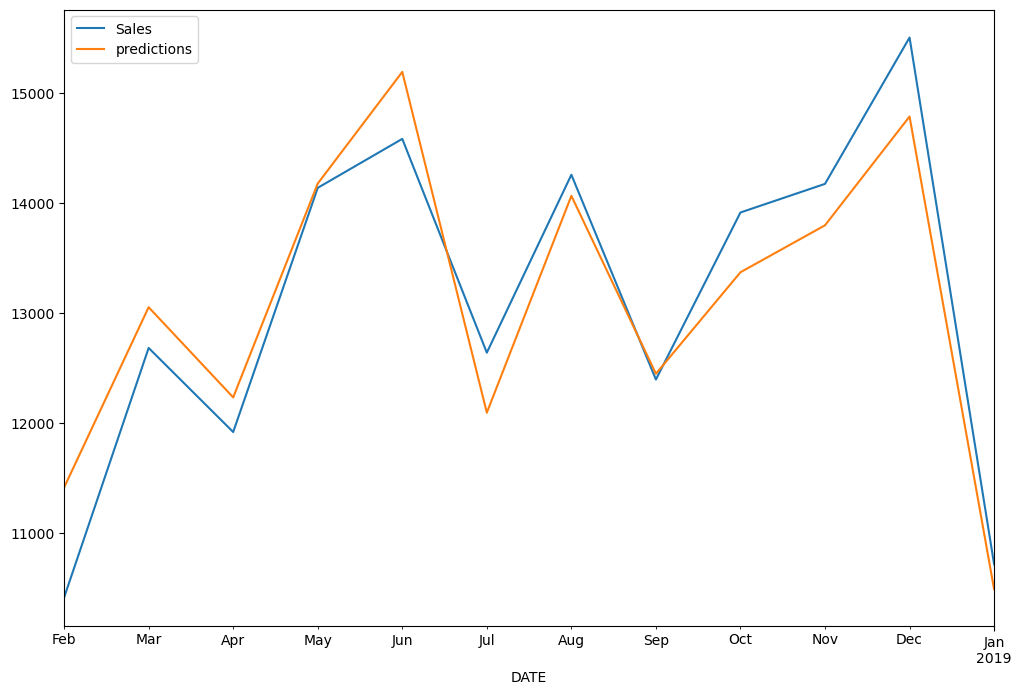

In [65]:
test.plot(legend=True,figsize=(12,8))